success_rate, time_taken, distance_travelled, straight_distance, (optimal_time or dijsktra_time)

In [131]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df = pd.read_csv('data_sorted.csv')
df.head()

,success,actual_time,optimal_time,world_idx,timestep,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,...,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,local_goal_x,local_goal_y
0,True,12.367,6.796149,0,0,2.970249,2.952848,2.942288,2.937646,2.942004,...,2.974557,-0.000416,0.006752,1.571106,0.054851,-0.000015,0.066,0.006651,-0.05,0.35
1,True,12.367,6.796149,0,1,2.970249,2.952848,2.942288,2.937646,2.942004,...,2.974500,-0.000416,0.006752,1.571106,0.054851,-0.000015,0.066,0.007315,-0.05,0.35
2,True,12.367,6.796149,0,2,2.970249,2.952848,2.942288,2.937646,2.942004,...,2.974500,-0.000416,0.006752,1.571106,0.054851,-0.000015,0.066,0.007315,-0.05,0.35
3,True,12.367,6.796149,0,3,2.970935,2.952720,2.942559,2.940268,2.943001,...,2.972595,-0.000417,0.008014,1.571247,0.060888,0.008210,0.072,0.007980,-0.05,0.35
4,True,12.367,6.796149,0,4,2.969906,2.953190,2.943104,2.942191,2.944316,...,2.972554,-0.000418,0.009397,1.571141,0.066950,-0.001348,0.078,0.008645,-0.05,0.35


In [132]:
df.describe()

,actual_time,optimal_time,world_idx,timestep,lidar_0,lidar_1,lidar_2,lidar_3,lidar_4,lidar_5,...,lidar_719,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,local_goal_x,local_goal_y
count,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,...,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000,200540.000000
mean,12.731146,5.705953,151.868460,340.027182,2.977978,2.973894,2.970005,2.966131,2.962435,2.956835,...,2.974177,-0.031480,4.134166,1.554468,0.709279,-0.001472,0.710038,-0.001961,-0.048144,4.451120
std,2.094962,0.366456,86.482099,205.708619,2.099984,2.112733,2.124795,2.136720,2.148487,2.159736,...,2.181376,0.524510,2.795738,0.346113,0.205768,0.248443,0.202546,0.219348,0.536361,2.801547
min,11.778000,5.026614,0.000000,0.000000,0.316017,0.312385,0.308484,0.304327,0.302636,0.299997,...,0.291395,-1.710844,-0.000102,-3.141033,-0.317507,-2.412546,-0.300000,-1.570796,-1.814288,0.293437
25%,11.923000,5.441711,78.000000,167.000000,1.693966,1.688156,1.682930,1.677800,1.673200,1.668052,...,1.612400,-0.294785,1.631851,1.467639,0.799555,-0.059794,0.800000,-0.065792,-0.325890,1.919969
50%,12.121000,5.612314,153.000000,335.000000,2.879627,2.865375,2.851746,2.838104,2.824749,2.811204,...,2.844913,-0.004195,4.014582,1.579035,0.800235,-0.000544,0.800000,0.000088,-0.050000,4.300000
75%,12.502000,5.891979,227.000000,503.000000,3.187622,3.172247,3.157621,3.144867,3.130252,3.113974,...,3.177820,0.217379,6.539444,1.680124,0.801052,0.044571,0.800000,0.052247,0.231511,6.875039
max,25.666000,6.867653,299.000000,1328.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,1.690635,9.312726,3.140765,0.810490,2.206750,0.800000,1.570796,1.689592,10.000000


In [133]:
# torch Dataset
from torch.utils.data import Dataset
import numpy as np
import json

class KULBarnDataset(Dataset):
    def get_local_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        theta = self.data['pose_heading']
        goal_x = self.data['local_goal_x']
        goal_y = self.data['local_goal_y']
        self.data['local_x'] = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
        self.data['local_y'] = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)
        self.data['distance'] = np.sqrt((goal_x - x)**2 + (goal_y - y)**2)
        self.data['local_x'] /= self.data['distance']
        self.data['local_y'] /= self.data['distance']
    
    def __init__(self, df, mode="train"):
        super().__init__()

        self.data = df
        self.get_local_goal()  
        
        self.data = self.data.drop(columns=[
            'world_idx', 'timestep', 'actual_time', 'optimal_time', 'success'
        ])

        # get all the column values that contain the word lidar
        self.lidar_cols = ["lidar_" + str(i) for i in range(0, 720, 1)]
        # get actions columns
        self.actions_cols = ['cmd_vel_linear', 'cmd_vel_angular']
        # get other columns
        self.non_lidar_cols = ['local_x', 'local_y', 'twist_linear', 'twist_angular']

        if mode == "train":
            # Manually compute the min and max values for each column
            self.min = self.data.min()
            self.max = self.data.max()

            # Save the mean and std to a JSON file
            scaler_params = {
                'min': self.min.to_dict(),
                'max': self.max.to_dict()
            }
            with open('scaler_params.json', 'w') as f:
                json.dump(scaler_params, f)
        else:
            # Load the mean and std from the JSON file
            with open('scaler_params.json', 'r') as f:
                scaler_params = json.load(f)
            self.min = pd.Series(scaler_params['min'])
            self.max = pd.Series(scaler_params['max'])
        
        # dont normalizer local_x and local_y
        self.normalized_data = (self.data - self.min) / (self.max - self.min)
        
        self.lidar_data = self.normalized_data[self.lidar_cols].values
        self.non_lidar_data = self.normalized_data[self.non_lidar_cols].values
        self.actions_data = self.normalized_data[self.actions_cols].values

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        lidar = self.lidar_data[idx]
        non_lidar = self.non_lidar_data[idx]
        actions = self.actions_data[idx]
        return lidar, non_lidar, actions

In [134]:
# split train and test
import random
# set random seed
random.seed(42)

NO_WORLDS = 300
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.2

world_ids = [i for i in range(NO_WORLDS)]
test_ids = [id for id in range(0, NO_WORLDS, 5)]
train_evals = [id for id in world_ids if id not in test_ids]
train_ids = random.sample(train_evals, int(NO_WORLDS * TRAIN_RATIO))
val_ids = [id for id in train_evals if id not in train_ids]

train_df = df[df['world_idx'].isin(train_ids)]
val_df = df[df['world_idx'].isin(val_ids)]

In [135]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

210
30
60


In [136]:
print(val_ids)

[12, 27, 37, 56, 57, 83, 98, 106, 107, 132, 142, 144, 149, 153, 154, 158, 166, 176, 187, 194, 221, 238, 242, 247, 253, 258, 262, 278, 286, 289]


In [137]:
print(len(train_df))
print(len(val_df))

140392
19838


In [138]:
train_dataset = KULBarnDataset(train_df, "train")
val_dataset = KULBarnDataset(val_df, "val")

In [139]:
print("Train Dataset Length:", len(train_dataset))
print("Val Dataset Length:", len(val_dataset))

Train Dataset Length: 140392
Val Dataset Length: 19838


In [140]:
# dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test dataloader
lidar, non_lidar, actions = next(iter(train_loader))
print(f"Non lidar shape: {non_lidar.shape}")
print(f"Lidar shape: {lidar.shape}")
# print size dataloader
print(f"Train loader size: {len(train_loader)}")
print(f"Val loader size: {len(val_loader)}")
print(lidar, non_lidar, actions)

Non lidar shape: torch.Size([64, 4])
Lidar shape: torch.Size([64, 720])
Train loader size: 2194
Val loader size: 310
tensor([[0.0572, 0.0575, 0.0584,  ..., 0.1002, 0.0980, 0.0842],
        [0.2878, 0.2861, 0.2856,  ..., 1.0000, 1.0000, 1.0000],
        [0.2623, 0.2621, 0.2620,  ..., 0.2854, 0.2876, 0.2951],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 0.1972, 0.1959, 0.1948],
        [0.3197, 0.3185, 0.3181,  ..., 1.0000, 1.0000, 1.0000],
        [0.4090, 0.4075, 0.4071,  ..., 1.0000, 1.0000, 1.0000]],
       dtype=torch.float64) tensor([[0.9910, 0.5945, 0.9920, 0.4639],
        [0.9971, 0.5536, 0.9913, 0.4979],
        [0.9983, 0.5412, 0.7446, 0.5244],
        [0.9984, 0.4606, 0.9924, 0.6320],
        [0.9991, 0.5302, 0.6822, 0.5620],
        [0.9995, 0.4781, 0.9925, 0.5063],
        [0.9988, 0.5352, 0.9950, 0.5208],
        [0.9979, 0.5462, 0.9948, 0.4022],
        [0.9949, 0.4285, 0.9940, 0.5229],
        [0.9994, 0.5247, 0.9920, 0.5205],
        [0.9994, 0.5235, 0.9709, 0.52

In [141]:
lidar

tensor([[0.0572, 0.0575, 0.0584,  ..., 0.1002, 0.0980, 0.0842],
        [0.2878, 0.2861, 0.2856,  ..., 1.0000, 1.0000, 1.0000],
        [0.2623, 0.2621, 0.2620,  ..., 0.2854, 0.2876, 0.2951],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 0.1972, 0.1959, 0.1948],
        [0.3197, 0.3185, 0.3181,  ..., 1.0000, 1.0000, 1.0000],
        [0.4090, 0.4075, 0.4071,  ..., 1.0000, 1.0000, 1.0000]],
       dtype=torch.float64)

In [142]:
non_lidar

tensor([[0.9910, 0.5945, 0.9920, 0.4639],
        [0.9971, 0.5536, 0.9913, 0.4979],
        [0.9983, 0.5412, 0.7446, 0.5244],
        [0.9984, 0.4606, 0.9924, 0.6320],
        [0.9991, 0.5302, 0.6822, 0.5620],
        [0.9995, 0.4781, 0.9925, 0.5063],
        [0.9988, 0.5352, 0.9950, 0.5208],
        [0.9979, 0.5462, 0.9948, 0.4022],
        [0.9949, 0.4285, 0.9940, 0.5229],
        [0.9994, 0.5247, 0.9920, 0.5205],
        [0.9994, 0.5235, 0.9709, 0.5218],
        [0.9999, 0.5107, 0.9912, 0.5222],
        [0.9999, 0.4927, 0.9915, 0.5344],
        [0.9914, 0.5923, 0.7525, 0.5490],
        [0.9642, 0.3141, 0.9937, 0.3351],
        [0.9955, 0.5666, 0.9918, 0.5458],
        [0.9995, 0.5213, 0.9924, 0.5211],
        [0.9534, 0.2892, 0.4853, 0.4467],
        [0.9997, 0.5165, 0.9966, 0.5167],
        [0.9995, 0.4770, 0.9920, 0.5262],
        [0.9997, 0.5173, 0.9917, 0.5433],
        [1.0000, 0.4955, 0.9960, 0.5195],
        [0.5504, 0.0025, 0.4522, 0.4136],
        [0.9981, 0.4568, 0.9919, 0

In [143]:
actions

tensor([[1.0000, 0.4192],
        [1.0000, 0.4759],
        [0.7582, 0.5126],
        [1.0000, 0.6241],
        [0.6927, 0.5416],
        [1.0000, 0.4926],
        [1.0000, 0.4939],
        [1.0000, 0.3220],
        [1.0000, 0.5446],
        [1.0000, 0.5005],
        [0.9873, 0.5029],
        [1.0000, 0.4952],
        [1.0000, 0.5175],
        [0.7636, 0.5822],
        [1.0000, 0.2753],
        [1.0000, 0.5284],
        [1.0000, 0.5023],
        [0.4964, 0.4386],
        [1.0000, 0.4972],
        [1.0000, 0.5239],
        [1.0000, 0.5245],
        [1.0000, 0.4932],
        [0.4545, 0.1937],
        [1.0000, 0.3507],
        [0.9873, 0.5243],
        [0.3182, 0.3432],
        [0.8073, 0.6369],
        [1.0000, 0.3889],
        [0.4527, 0.5000],
        [0.4309, 0.4987],
        [1.0000, 0.5000],
        [1.0000, 0.5178],
        [1.0000, 0.4899],
        [1.0000, 0.5314],
        [1.0000, 0.4628],
        [1.0000, 0.7039],
        [1.0000, 0.5117],
        [1.0000, 0.4771],
        [1.0

In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, nframes=1):
        super(CNNModel, self).__init__()
        self.act_fea_cv1 = nn.Conv1d(
            in_channels=nframes, out_channels=32, kernel_size=5, stride=2, padding=6, padding_mode='circular'
        )
        self.act_fea_cv2 = nn.Conv1d(
            in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1
        )

        conv_output_size = (num_lidar_features - 5 + 2*6) // 2 + 1  # Output size after self.act_fea_cv1
        conv_output_size = (conv_output_size - 3 + 2*1) // 2 + 1  # Output size after self.act_fea_cv2
        conv_output_size *= 32  # Multiply by the number of output channels

        # Calculate the output size of the CNN
        self.fc1 = nn.Linear(conv_output_size, 64)
        self.fc2 = nn.Linear(64 + num_non_lidar_features, 32)
        self.fc3 = nn.Linear(32, num_actions)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, lidar, non_lidar):
        lidar = lidar.unsqueeze(1)  # Add channel dimension
        feat = F.relu(self.act_fea_cv1(lidar))
        feat = F.relu(self.act_fea_cv2(feat))
        feat = feat.view(feat.shape[0], -1)
        feat = F.relu(self.fc1(feat))
        feat = torch.cat((feat, non_lidar), dim=-1)
        feat = F.relu(self.fc2(feat))
        feat = self.fc3(feat)
        return feat

In [145]:
# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)
model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cuda


In [165]:
from tqdm import tqdm

def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions in tqdm(train_loader):

        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [166]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [167]:
import sys
NUM_EPOCHS = 0

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)
sys.stdout.flush()

cnn_train_losses = []
cnn_val_losses = []
best_val_loss = float('inf')
patience = 3
no_improve_epochs = 0

for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    val_loss = test_model(model, val_loader, loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}")
    sys.stdout.flush()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement after {} epochs.".format(patience))
            break

100%|██████████| 310/310 [00:01<00:00, 206.92it/s]

Random val loss: 0.11803823808929131


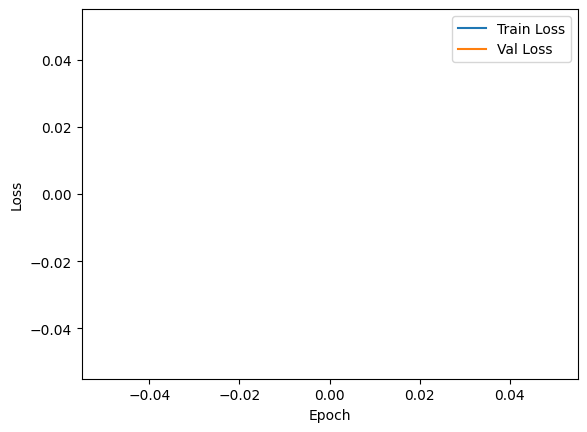

In [168]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [169]:
# save the model
torch.save(model.state_dict(), 'cnn_model.pth')

In [170]:
# # load file and check MSELoss
# model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)
# model.load_state_dict(torch.load('cnn_model.pth', map_location=torch.device('cpu')))
# model.eval()
# device = 'cpu'

# # take world idx 0 as example
# dataset = KULBarnDataset(df[df['world_idx'] == 0][df['timestep']>0], "val")
# loader = DataLoader(dataset, batch_size=1, shuffle=False)

# final_val_loss = test_model(model, loader, loss_fn)
# print("Final val loss:", final_val_loss)

In [171]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, d_model=64, nhead=4, num_encoder_layers=3, num_patches=36):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.num_patches = num_patches  # Number of patches
        self.patch_size = num_lidar_features // self.num_patches

        # Positional Encoding for the Encoder
        self.positional_encoding = nn.Parameter(torch.zeros(self.num_patches, d_model))

        # Input Embedding for Encoder (LiDAR data)
        self.lidar_embedding = nn.Linear(self.patch_size, d_model)

        # Transformer Encoder for LiDAR data (first encoder)
        encoder_layer_1 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder_1 = nn.TransformerEncoder(encoder_layer_1, num_layers=num_encoder_layers)

        # Input Embedding for Non-LiDAR data (values)
        self.non_lidar_embedding = nn.Linear(num_non_lidar_features, d_model)

        # Transformer Decoder (cross-attention using Q and K from LiDAR encoder and V from non-lidar data)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead)
        self.norm_1 = nn.LayerNorm(d_model)
        self.ff = nn.Linear(d_model, d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        # Second Encoder Layer for post-processing
        encoder_layer_2 = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder_2 = nn.TransformerEncoder(encoder_layer_2, num_layers=num_encoder_layers-1)

        # Linear layer to map the transformer output to actions
        self.fc_out = nn.Linear(d_model * num_patches, num_actions)

        self.sigmoid = nn.Sigmoid()

    def forward(self, lidar, non_lidar):
        batch_size = lidar.size(0)
        
        # Reshape LiDAR input into patches
        lidar_patches = lidar.view(batch_size, self.num_patches, self.patch_size)

        # Linear projection of LiDAR patches and adding positional encoding
        lidar_embed = self.lidar_embedding(lidar_patches) + self.positional_encoding.unsqueeze(0).expand(batch_size, -1, -1)
        lidar_embed = lidar_embed.permute(1, 0, 2)  # Convert to (seq_len, batch_size, d_model)

        # Process through the transformer encoder for LiDAR data
        lidar_encoded = self.transformer_encoder_1(lidar_embed)  # Shape: (seq_len, batch_size, d_model)

        # Process non-lidar data through input embedding
        non_lidar_embed = self.non_lidar_embedding(non_lidar).unsqueeze(0)  # Shape: (1, batch_size, d_model)

        # Repeat the non-lidar embeddings along the sequence length to match the LiDAR sequence length
        non_lidar_embed = non_lidar_embed.repeat(self.num_patches, 1, 1)  # Shape: (seq_len, batch_size, d_model)

        # Cross-attention: Use LiDAR encoded data as Q and K, non-lidar as V
        non_lidar_attended, _ = self.multihead_attention(query=lidar_encoded, key=lidar_encoded, value=non_lidar_embed)
        non_lidar_embedding = self.norm_1(non_lidar_attended + non_lidar_embed)
        non_lidar_ff = self.ff(non_lidar_attended)
        non_lidar_embedding = self.norm_2(non_lidar_ff + non_lidar_attended)

        # Process the output of the cross-attention through the second encoder layer
        encoder_output = self.transformer_encoder_2(non_lidar_embedding)  # (seq_len, batch_size, d_model)

        # Concatenate the encoder output over the sequence length
        encoder_output = encoder_output.permute(1, 0, 2)
        encoder_output = encoder_output.reshape(batch_size, -1)

        # Final linear layer to get the predicted actions
        actions = self.fc_out(encoder_output)

        actions = self.sigmoid(actions)
        
        return actions

In [172]:
# class CustomMSELoss(nn.Module):
#     def __init__(self, weight):
#         super(CustomMSELoss, self).__init__()
#         self.weight = weight

#     def forward(self, output, target):
#         # Assume output and target are two-element tuples
#         loss1 = (output[:,0] - target[:,0]) ** 2
#         loss2 = self.weight * (output[:,1] - target[:,1]) ** 4
#         total_loss = loss1 + loss2
#         return total_loss.mean()

In [173]:
# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)
model = TransformerModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cuda


In [174]:
import sys
NUM_EPOCHS = 20

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)

transformer_train_losses = []
transformer_val_losses = []
best_val_loss = float('inf')
patience = 3
no_improve_epochs = 0

for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    val_loss = test_model(model, val_loader, loss_fn)
    transformer_train_losses.append(train_loss)
    transformer_val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}")
    sys.stdout.flush()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement after {} epochs.".format(patience))
            break

100%|██████████| 310/310 [00:02<00:00, 152.68it/s]


Random val loss: 0.14672352211369621


100%|██████████| 310/310 [00:01<00:00, 222.41it/s]

Epoch 1/20 | Train Loss: 0.022565175893987335 | Val Loss: 0.006304118891186532



100%|██████████| 310/310 [00:01<00:00, 230.38it/s]

Epoch 2/20 | Train Loss: 0.0033379217094861467 | Val Loss: 0.0013619818781960696



100%|██████████| 310/310 [00:01<00:00, 210.97it/s]

Epoch 3/20 | Train Loss: 0.0019285483958860546 | Val Loss: 0.000952554183905088



100%|██████████| 310/310 [00:01<00:00, 209.50it/s]

Epoch 4/20 | Train Loss: 0.0014891498964889028 | Val Loss: 0.0007797201114778047



100%|██████████| 310/310 [00:01<00:00, 200.92it/s]

Epoch 5/20 | Train Loss: 0.0012422839529756516 | Val Loss: 0.000686960464360797



100%|██████████| 310/310 [00:03<00:00, 96.01it/s] 

Epoch 6/20 | Train Loss: 0.0011009623822735948 | Val Loss: 0.0006510963050870135



100%|██████████| 310/310 [00:03<00:00, 84.45it/s]

Epoch 7/20 | Train Loss: 0.0010199386138269896 | Val Loss: 0.000623969144174724



100%|██████████| 310/310 [00:03<00:00, 82.07it/s] 

Epoch 8/20 | Train Loss: 0.000959980379889928 | Val Loss: 0.000605692127224287



100%|██████████| 310/310 [00:01<00:00, 189.19it/s]

Epoch 9/20 | Train Loss: 0.0009133712093000077 | Val Loss: 0.0005880626969971467



100%|██████████| 310/310 [00:01<00:00, 176.88it/s]

Epoch 10/20 | Train Loss: 0.0008779871298868078 | Val Loss: 0.000575486867508575



100%|██████████| 310/310 [00:01<00:00, 197.64it/s]

Epoch 11/20 | Train Loss: 0.0008503863842242695 | Val Loss: 0.0005732788723171032



100%|██████████| 310/310 [00:01<00:00, 180.06it/s]

Epoch 12/20 | Train Loss: 0.0008324217713267013 | Val Loss: 0.0005600574206739346



100%|██████████| 310/310 [00:02<00:00, 154.55it/s]

Epoch 13/20 | Train Loss: 0.0008138336873848994 | Val Loss: 0.0005564762062447464



100%|██████████| 310/310 [00:02<00:00, 135.90it/s]

Epoch 14/20 | Train Loss: 0.000793347891282221 | Val Loss: 0.0005482638171425576



100%|██████████| 310/310 [00:01<00:00, 156.53it/s]

Epoch 15/20 | Train Loss: 0.0007808991060745579 | Val Loss: 0.0005538729945798086



100%|██████████| 310/310 [00:01<00:00, 155.98it/s]

Epoch 16/20 | Train Loss: 0.0007684485373021856 | Val Loss: 0.0005588311778527925



100%|██████████| 310/310 [00:02<00:00, 149.39it/s]

Epoch 17/20 | Train Loss: 0.0007573100525254716 | Val Loss: 0.000541816550738135



100%|██████████| 310/310 [00:02<00:00, 154.94it/s]

Epoch 18/20 | Train Loss: 0.0007496677209502604 | Val Loss: 0.0005416472970248452



100%|██████████| 310/310 [00:02<00:00, 142.26it/s]

Epoch 19/20 | Train Loss: 0.0007374043926461231 | Val Loss: 0.0005331481486116959



100%|██████████| 310/310 [00:01<00:00, 203.79it/s]

Epoch 20/20 | Train Loss: 0.000731849411303821 | Val Loss: 0.0005322198183655987


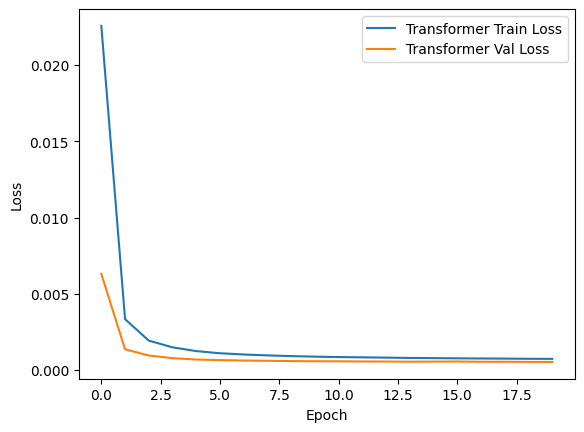

In [175]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(transformer_train_losses, label='Transformer Train Loss')  
plt.plot(transformer_val_losses, label='Transformer Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [176]:
# save the model
torch.save(model.state_dict(), 'transformer_model.pth')

In [177]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device)
        non_lidar = non_lidar.to(device)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())        
        loss = loss_fn(actions_pred, actions.float())

        print(non_lidar)
        print(actions_pred)
        print(actions)
        print(loss)

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [178]:
# load file and check MSELoss
model = TransformerModel(num_lidar_features, num_non_lidar_features, num_actions)
model.load_state_dict(torch.load('transformer_model.pth', map_location=torch.device('cpu')))
model.eval()
device = 'cpu'

# take world idx 0 as example
dataset = KULBarnDataset(df[df['world_idx'] == 0], "val")
print(len(dataset))
loader = DataLoader(dataset, batch_size=1, shuffle=False)

final_val_loss = test_model(model, loader, loss_fn)
print("Final val loss:", final_val_loss)

665


  0%|          | 0/665 [00:00<?, ?it/s]

  1%|▏         | 9/665 [00:00<00:07, 86.12it/s]

tensor([[0.9949, 0.5713, 0.3246, 0.5223]], dtype=torch.float64)
tensor([[0.3382, 0.5077]], grad_fn=<SigmoidBackward0>)
tensor([[0.3327, 0.5021]], dtype=torch.float64)
tensor(3.0956e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9949, 0.5713, 0.3246, 0.5223]], dtype=torch.float64)
tensor([[0.3382, 0.5077]], grad_fn=<SigmoidBackward0>)
tensor([[0.3327, 0.5023]], dtype=torch.float64)
tensor(2.9787e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9949, 0.5713, 0.3246, 0.5223]], dtype=torch.float64)
tensor([[0.3382, 0.5077]], grad_fn=<SigmoidBackward0>)
tensor([[0.3327, 0.5023]], dtype=torch.float64)
tensor(2.9787e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9949, 0.5715, 0.3300, 0.5241]], dtype=torch.float64)
tensor([[0.3433, 0.5091]], grad_fn=<SigmoidBackward0>)
tensor([[0.3382, 0.5025]], dtype=torch.float64)
tensor(3.4320e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9948, 0.5719, 0.3355, 0.5220]], dtype=torch.float64)
tensor([[0.3485, 0.5074]], grad_fn=<SigmoidBackward0>)
tensor([[0.3436, 0.5028]]

  4%|▍         | 26/665 [00:00<00:09, 70.27it/s]

tensor([[0.9948, 0.5717, 0.4005, 0.5227]], dtype=torch.float64)
tensor([[0.4141, 0.5069]], grad_fn=<SigmoidBackward0>)
tensor([[0.4091, 0.5053]], dtype=torch.float64)
tensor(1.4002e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9948, 0.5722, 0.4059, 0.5231]], dtype=torch.float64)
tensor([[0.4199, 0.5073]], grad_fn=<SigmoidBackward0>)
tensor([[0.4145, 0.5055]], dtype=torch.float64)
tensor(1.6179e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9947, 0.5728, 0.4114, 0.5238]], dtype=torch.float64)
tensor([[0.4259, 0.5080]], grad_fn=<SigmoidBackward0>)
tensor([[0.4200, 0.5058]], dtype=torch.float64)
tensor(1.9838e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9946, 0.5734, 0.4169, 0.5240]], dtype=torch.float64)
tensor([[0.4318, 0.5083]], grad_fn=<SigmoidBackward0>)
tensor([[0.4255, 0.5060]], dtype=torch.float64)
tensor(2.2811e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9945, 0.5740, 0.4223, 0.5247]], dtype=torch.float64)
tensor([[0.4377, 0.5090]], grad_fn=<SigmoidBackward0>)
tensor([[0.4309, 0.5066]]

  6%|▌         | 41/665 [00:00<00:09, 68.52it/s]

tensor([[0.9946, 0.5736, 0.4659, 0.5274]], dtype=torch.float64)
tensor([[0.4848, 0.5120]], grad_fn=<SigmoidBackward0>)
tensor([[0.4745, 0.5067]], dtype=torch.float64)
tensor(6.6117e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9952, 0.5689, 0.4713, 0.5278]], dtype=torch.float64)
tensor([[0.4904, 0.5116]], grad_fn=<SigmoidBackward0>)
tensor([[0.4800, 0.5068]], dtype=torch.float64)
tensor(6.5717e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9951, 0.5696, 0.4767, 0.5272]], dtype=torch.float64)
tensor([[0.4960, 0.5113]], grad_fn=<SigmoidBackward0>)
tensor([[0.4855, 0.5070]], dtype=torch.float64)
tensor(6.4947e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9950, 0.5702, 0.4821, 0.5284]], dtype=torch.float64)
tensor([[0.5015, 0.5126]], grad_fn=<SigmoidBackward0>)
tensor([[0.4909, 0.5072]], dtype=torch.float64)
tensor(7.0963e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9949, 0.5710, 0.4874, 0.5292]], dtype=torch.float64)
tensor([[0.5069, 0.5136]], grad_fn=<SigmoidBackward0>)
tensor([[0.4964, 0.5074]]

  8%|▊         | 56/665 [00:00<00:08, 68.90it/s]

tensor([[0.9959, 0.5642, 0.5466, 0.5279]], dtype=torch.float64)
tensor([[0.5660, 0.5131]], grad_fn=<SigmoidBackward0>)
tensor([[0.5564, 0.5078]], dtype=torch.float64)
tensor(6.0865e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9957, 0.5655, 0.5520, 0.5232]], dtype=torch.float64)
tensor([[0.5711, 0.5089]], grad_fn=<SigmoidBackward0>)
tensor([[0.5618, 0.5079]], dtype=torch.float64)
tensor(4.3940e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9955, 0.5666, 0.5573, 0.5241]], dtype=torch.float64)
tensor([[0.5764, 0.5100]], grad_fn=<SigmoidBackward0>)
tensor([[0.5673, 0.5075]], dtype=torch.float64)
tensor(4.5131e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9954, 0.5680, 0.5627, 0.5212]], dtype=torch.float64)
tensor([[0.5816, 0.5076]], grad_fn=<SigmoidBackward0>)
tensor([[0.5727, 0.5076]], dtype=torch.float64)
tensor(3.8950e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9959, 0.5639, 0.5682, 0.5214]], dtype=torch.float64)
tensor([[0.5870, 0.5073]], grad_fn=<SigmoidBackward0>)
tensor([[0.5782, 0.5080]]

 11%|█         | 72/665 [00:01<00:08, 73.26it/s]

tensor([[0.9959, 0.5639, 0.6165, 0.5295]], dtype=torch.float64)
tensor([[0.6339, 0.5159]], grad_fn=<SigmoidBackward0>)
tensor([[0.6273, 0.5086]], dtype=torch.float64)
tensor(4.8197e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9964, 0.5600, 0.6219, 0.5281]], dtype=torch.float64)
tensor([[0.6391, 0.5139]], grad_fn=<SigmoidBackward0>)
tensor([[0.6327, 0.5088]], dtype=torch.float64)
tensor(3.3675e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9963, 0.5611, 0.6274, 0.5282]], dtype=torch.float64)
tensor([[0.6443, 0.5143]], grad_fn=<SigmoidBackward0>)
tensor([[0.6382, 0.5089]], dtype=torch.float64)
tensor(3.2986e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9961, 0.5623, 0.6327, 0.5275]], dtype=torch.float64)
tensor([[0.6493, 0.5139]], grad_fn=<SigmoidBackward0>)
tensor([[0.6436, 0.5090]], dtype=torch.float64)
tensor(2.7986e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9966, 0.5584, 0.6382, 0.5295]], dtype=torch.float64)
tensor([[0.6547, 0.5153]], grad_fn=<SigmoidBackward0>)
tensor([[0.6491, 0.5082]]

 12%|█▏        | 81/665 [00:01<00:07, 75.38it/s]

tensor([[0.9970, 0.5548, 0.7037, 0.5258]], dtype=torch.float64)
tensor([[0.7164, 0.5114]], grad_fn=<SigmoidBackward0>)
tensor([[0.7145, 0.5078]], dtype=torch.float64)
tensor(7.9634e-06, grad_fn=<MseLossBackward0>)
tensor([[0.9968, 0.5561, 0.7091, 0.5263]], dtype=torch.float64)
tensor([[0.7214, 0.5121]], grad_fn=<SigmoidBackward0>)
tensor([[0.7200, 0.5079]], dtype=torch.float64)
tensor(9.9319e-06, grad_fn=<MseLossBackward0>)
tensor([[0.9972, 0.5525, 0.7145, 0.5279]], dtype=torch.float64)
tensor([[0.7265, 0.5133]], grad_fn=<SigmoidBackward0>)
tensor([[0.7255, 0.5080]], dtype=torch.float64)
tensor(1.4538e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9971, 0.5537, 0.7198, 0.5289]], dtype=torch.float64)
tensor([[0.7314, 0.5146]], grad_fn=<SigmoidBackward0>)
tensor([[0.7309, 0.5072]], dtype=torch.float64)
tensor(2.7216e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9970, 0.5551, 0.7252, 0.5277]], dtype=torch.float64)
tensor([[0.7363, 0.5136]], grad_fn=<SigmoidBackward0>)
tensor([[0.7364, 0.5073]]

 17%|█▋        | 115/665 [00:01<00:05, 99.54it/s]

tensor([[0.9979, 0.5462, 0.7944, 0.5261]], dtype=torch.float64)
tensor([[0.7999, 0.5110]], grad_fn=<SigmoidBackward0>)
tensor([[0.8073, 0.5061]], dtype=torch.float64)
tensor(3.9147e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9977, 0.5479, 0.8000, 0.5230]], dtype=torch.float64)
tensor([[0.8049, 0.5076]], grad_fn=<SigmoidBackward0>)
tensor([[0.8127, 0.5054]], dtype=torch.float64)
tensor(3.2738e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9980, 0.5448, 0.8057, 0.5258]], dtype=torch.float64)
tensor([[0.8103, 0.5102]], grad_fn=<SigmoidBackward0>)
tensor([[0.8182, 0.5054]], dtype=torch.float64)
tensor(4.2838e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9978, 0.5465, 0.8112, 0.5233]], dtype=torch.float64)
tensor([[0.8153, 0.5075]], grad_fn=<SigmoidBackward0>)
tensor([[0.8236, 0.5055]], dtype=torch.float64)
tensor(3.6905e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9981, 0.5436, 0.8164, 0.5231]], dtype=torch.float64)
tensor([[0.8201, 0.5067]], grad_fn=<SigmoidBackward0>)
tensor([[0.8291, 0.5060]]

 19%|█▉        | 126/665 [00:01<00:05, 100.71it/s]

tensor([[0.9992, 0.5280, 0.9347, 0.5233]], dtype=torch.float64)
tensor([[0.9697, 0.5020]], grad_fn=<SigmoidBackward0>)
tensor([[0.9491, 0.4932]], dtype=torch.float64)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor([[0.9991, 0.5294, 0.9403, 0.5210]], dtype=torch.float64)
tensor([[0.9744, 0.4991]], grad_fn=<SigmoidBackward0>)
tensor([[0.9545, 0.4932]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[0.9993, 0.5273, 0.9457, 0.5179]], dtype=torch.float64)
tensor([[0.9784, 0.4952]], grad_fn=<SigmoidBackward0>)
tensor([[0.9600, 0.4921]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[0.9992, 0.5287, 0.9511, 0.5182]], dtype=torch.float64)
tensor([[0.9816, 0.4955]], grad_fn=<SigmoidBackward0>)
tensor([[0.9655, 0.4920]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[0.9993, 0.5270, 0.9566, 0.5164]], dtype=torch.float64)
tensor([[0.9845, 0.4934]], grad_fn=<SigmoidBackward0>)
tensor([[0.9709, 0.4919]], dtype=torch.fl

 22%|██▏       | 148/665 [00:01<00:05, 99.83it/s] 

tensor([[0.9996, 0.5203, 0.9951, 0.5135]], dtype=torch.float64)
tensor([[0.9952, 0.4915]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4882]], dtype=torch.float64)
tensor(1.6971e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9996, 0.5193, 0.9952, 0.5142]], dtype=torch.float64)
tensor([[0.9952, 0.4924]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4882]], dtype=torch.float64)
tensor(2.0473e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9996, 0.5206, 0.9952, 0.5133]], dtype=torch.float64)
tensor([[0.9952, 0.4912]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4882]], dtype=torch.float64)
tensor(1.5893e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9996, 0.5197, 0.9953, 0.5139]], dtype=torch.float64)
tensor([[0.9952, 0.4921]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4891]], dtype=torch.float64)
tensor(1.5716e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9996, 0.5188, 0.9953, 0.5137]], dtype=torch.float64)
tensor([[0.9952, 0.4918]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4891]]

 26%|██▌       | 171/665 [00:01<00:04, 103.65it/s]

tensor([[0.9997, 0.5160, 0.9953, 0.4749]], dtype=torch.float64)
tensor([[0.9956, 0.4442]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4459]], dtype=torch.float64)
tensor(1.0978e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9995, 0.5225, 0.9946, 0.4720]], dtype=torch.float64)
tensor([[0.9955, 0.4405]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4459]], dtype=torch.float64)
tensor(2.4452e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9993, 0.5259, 0.9944, 0.4720]], dtype=torch.float64)
tensor([[0.9955, 0.4403]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4531]], dtype=torch.float64)
tensor(9.1132e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9995, 0.5221, 0.9943, 0.4720]], dtype=torch.float64)
tensor([[0.9955, 0.4404]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4531]], dtype=torch.float64)
tensor(8.9654e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9987, 0.5359, 0.9943, 0.4781]], dtype=torch.float64)
tensor([[0.9954, 0.4471]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4363]]

 29%|██▉       | 194/665 [00:02<00:04, 107.70it/s]

tensor([[0.8470, 0.8600, 0.9937, 0.5399]], dtype=torch.float64)
tensor([[0.9964, 0.5678]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.9152]], dtype=torch.float64)
tensor(0.0604, grad_fn=<MseLossBackward0>)
tensor([[0.8413, 0.8654, 0.9938, 0.5779]], dtype=torch.float64)
tensor([[0.9959, 0.6198]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.9209]], dtype=torch.float64)
tensor(0.0453, grad_fn=<MseLossBackward0>)
tensor([[0.8322, 0.8737, 0.9938, 0.6147]], dtype=torch.float64)
tensor([[0.9955, 0.6671]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.9209]], dtype=torch.float64)
tensor(0.0322, grad_fn=<MseLossBackward0>)
tensor([[0.8466, 0.8603, 0.9937, 0.6490]], dtype=torch.float64)
tensor([[0.9947, 0.7022]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.3440]], dtype=torch.float64)
tensor(0.0642, grad_fn=<MseLossBackward0>)
tensor([[0.8400, 0.8666, 0.9937, 0.6801]], dtype=torch.float64)
tensor([[0.9942, 0.7347]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.3440]], dtype=torch.fl

 33%|███▎      | 218/665 [00:02<00:04, 109.98it/s]

tensor([[0.9891, 0.3964, 0.9934, 0.3700]], dtype=torch.float64)
tensor([[0.9963, 0.3255]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.3453]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[0.9896, 0.3983, 0.9933, 0.3715]], dtype=torch.float64)
tensor([[0.9962, 0.3273]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.3453]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[0.9892, 0.3965, 0.9932, 0.3809]], dtype=torch.float64)
tensor([[0.9962, 0.3375]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.3453]], dtype=torch.float64)
tensor(3.7683e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9894, 0.3977, 0.9931, 0.3856]], dtype=torch.float64)
tensor([[0.9962, 0.3427]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.3594]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[0.9893, 0.3971, 0.9931, 0.3825]], dtype=torch.float64)
tensor([[0.9962, 0.3392]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.3594]], dtype=torc

 36%|███▋      | 242/665 [00:02<00:03, 111.16it/s]

tensor([[0.9973, 0.4479, 0.9927, 0.4383]], dtype=torch.float64)
tensor([[0.9958, 0.4033]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4206]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[0.9973, 0.4486, 0.9926, 0.4476]], dtype=torch.float64)
tensor([[0.9958, 0.4144]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4206]], dtype=torch.float64)
tensor(2.8451e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9993, 0.4729, 0.9920, 0.4648]], dtype=torch.float64)
tensor([[0.9954, 0.4341]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4206]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[0.9990, 0.4692, 0.9920, 0.4810]], dtype=torch.float64)
tensor([[0.9953, 0.4540]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4282]], dtype=torch.float64)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor([[0.9990, 0.4680, 0.9921, 0.4994]], dtype=torch.float64)
tensor([[0.9952, 0.4771]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4282]], dtype=torc

 38%|███▊      | 254/665 [00:02<00:04, 94.05it/s] 

tensor([[0.9995, 0.4767, 0.9923, 0.4542]], dtype=torch.float64)
tensor([[0.9955, 0.4212]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4364]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[0.9995, 0.4774, 0.9920, 0.4552]], dtype=torch.float64)
tensor([[0.9955, 0.4223]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4367]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.5045, 0.9918, 0.4625]], dtype=torch.float64)
tensor([[0.9953, 0.4298]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4367]], dtype=torch.float64)
tensor(3.4815e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.5038, 0.9918, 0.4632]], dtype=torch.float64)
tensor([[0.9953, 0.4307]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4496]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.5064, 0.9921, 0.4672]], dtype=torch.float64)
tensor([[0.9953, 0.4353]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4462]], dtype=torc

 41%|████▏     | 275/665 [00:03<00:04, 86.06it/s]

tensor([[1.0000, 0.4985, 0.9924, 0.4731]], dtype=torch.float64)
tensor([[0.9953, 0.4429]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4478]], dtype=torch.float64)
tensor(2.3168e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4972, 0.9922, 0.4751]], dtype=torch.float64)
tensor([[0.9953, 0.4453]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4487]], dtype=torch.float64)
tensor(1.6907e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4963, 0.9921, 0.4734]], dtype=torch.float64)
tensor([[0.9953, 0.4433]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4488]], dtype=torch.float64)
tensor(2.6189e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4940, 0.9921, 0.4723]], dtype=torch.float64)
tensor([[0.9953, 0.4421]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4483]], dtype=torch.float64)
tensor(3.0644e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4935, 0.9920, 0.4716]], dtype=torch.float64)
tensor([[0.9953, 0.4412]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4484]]

 43%|████▎     | 284/665 [00:03<00:04, 81.33it/s]

tensor([[0.9999, 0.4889, 0.9927, 0.5080]], dtype=torch.float64)
tensor([[0.9951, 0.4865]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4773]], dtype=torch.float64)
tensor(5.4925e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.5004, 0.9923, 0.5061]], dtype=torch.float64)
tensor([[0.9950, 0.4833]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4754]], dtype=torch.float64)
tensor(4.3679e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4990, 0.9923, 0.5023]], dtype=torch.float64)
tensor([[0.9950, 0.4786]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4739]], dtype=torch.float64)
tensor(2.3579e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.5000, 0.9923, 0.5002]], dtype=torch.float64)
tensor([[0.9950, 0.4759]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4739]], dtype=torch.float64)
tensor(1.4294e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4967, 0.9922, 0.5007]], dtype=torch.float64)
tensor([[0.9950, 0.4769]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4758]]

 45%|████▌     | 302/665 [00:03<00:04, 75.04it/s]

tensor([[1.0000, 0.5025, 0.9921, 0.5115]], dtype=torch.float64)
tensor([[0.9949, 0.4900]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5177]], dtype=torch.float64)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor([[0.9990, 0.4689, 0.9921, 0.5298]], dtype=torch.float64)
tensor([[0.9948, 0.5155]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5169]], dtype=torch.float64)
tensor(1.4325e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9989, 0.4667, 0.9921, 0.5350]], dtype=torch.float64)
tensor([[0.9948, 0.5224]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5201]], dtype=torch.float64)
tensor(1.6333e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9993, 0.4728, 0.9922, 0.5344]], dtype=torch.float64)
tensor([[0.9947, 0.5211]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5202]], dtype=torch.float64)
tensor(1.4187e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9998, 0.4864, 0.9920, 0.5382]], dtype=torch.float64)
tensor([[0.9946, 0.5249]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5296]], dt

 48%|████▊     | 321/665 [00:03<00:04, 81.11it/s]

tensor([[0.9785, 0.3548, 0.9918, 0.5343]], dtype=torch.float64)
tensor([[0.9952, 0.5176]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5064]], dtype=torch.float64)
tensor(7.4441e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9893, 0.3970, 0.9919, 0.5350]], dtype=torch.float64)
tensor([[0.9951, 0.5255]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5325]], dtype=torch.float64)
tensor(3.6420e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9882, 0.3918, 0.9919, 0.5301]], dtype=torch.float64)
tensor([[0.9952, 0.5193]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5333]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[0.9900, 0.4006, 0.9919, 0.5308]], dtype=torch.float64)
tensor([[0.9951, 0.5205]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5137]], dtype=torch.float64)
tensor(3.4540e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9900, 0.4006, 0.9919, 0.5308]], dtype=torch.float64)
tensor([[0.9951, 0.5205]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5137]], dt

 51%|█████     | 339/665 [00:03<00:04, 77.13it/s]

tensor([[0.9966, 0.4415, 0.9918, 0.7652]], dtype=torch.float64)
tensor([[0.9886, 0.7499]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.7578]], dtype=torch.float64)
tensor(9.5869e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9967, 0.4429, 0.9917, 0.7593]], dtype=torch.float64)
tensor([[0.9888, 0.7459]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.7578]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[0.9977, 0.4524, 0.9917, 0.7534]], dtype=torch.float64)
tensor([[0.9890, 0.7431]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.6947]], dtype=torch.float64)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor([[0.9990, 0.4686, 0.9919, 0.7529]], dtype=torch.float64)
tensor([[0.9890, 0.7452]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.6814]], dtype=torch.float64)
tensor(0.0021, grad_fn=<MseLossBackward0>)
tensor([[0.9995, 0.4778, 0.9917, 0.7261]], dtype=torch.float64)
tensor([[0.9899, 0.7247]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.6814]], dtype=torc

 54%|█████▎    | 357/665 [00:04<00:03, 77.73it/s]

tensor([[0.9999, 0.4918, 0.9915, 0.7172]], dtype=torch.float64)
tensor([[0.9901, 0.7183]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.7219]], dtype=torch.float64)
tensor(5.5873e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4941, 0.9917, 0.7085]], dtype=torch.float64)
tensor([[0.9904, 0.7108]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.7084]], dtype=torch.float64)
tensor(4.9361e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9998, 0.4851, 0.9918, 0.7079]], dtype=torch.float64)
tensor([[0.9905, 0.7097]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.7040]], dtype=torch.float64)
tensor(6.1702e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4976, 0.9919, 0.7042]], dtype=torch.float64)
tensor([[0.9905, 0.7071]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.7007]], dtype=torch.float64)
tensor(6.5548e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.5053, 0.9922, 0.7084]], dtype=torch.float64)
tensor([[0.9904, 0.7114]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.7197]]

 56%|█████▋    | 375/665 [00:04<00:03, 78.67it/s]

tensor([[0.9942, 0.5761, 0.9918, 0.6850]], dtype=torch.float64)
tensor([[0.9907, 0.6923]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.6749]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[0.9898, 0.6003, 0.9918, 0.6863]], dtype=torch.float64)
tensor([[0.9906, 0.6957]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.6749]], dtype=torch.float64)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor([[0.9904, 0.5976, 0.9917, 0.6849]], dtype=torch.float64)
tensor([[0.9907, 0.6938]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.6411]], dtype=torch.float64)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor([[0.9878, 0.6099, 0.9918, 0.6867]], dtype=torch.float64)
tensor([[0.9906, 0.6971]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.6411]], dtype=torch.float64)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor([[0.9862, 0.6166, 0.9916, 0.6710]], dtype=torch.float64)
tensor([[0.9910, 0.6808]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.6099]], dtype=torch.fl

 58%|█████▊    | 385/665 [00:04<00:03, 81.98it/s]

tensor([[0.9876, 0.6106, 0.9919, 0.5381]], dtype=torch.float64)
tensor([[0.9942, 0.5176]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5127]], dtype=torch.float64)
tensor(2.8653e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9904, 0.5977, 0.9919, 0.5328]], dtype=torch.float64)
tensor([[0.9943, 0.5113]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5106]], dtype=torch.float64)
tensor(1.6521e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9924, 0.5867, 0.9920, 0.5333]], dtype=torch.float64)
tensor([[0.9943, 0.5124]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5106]], dtype=torch.float64)
tensor(1.7791e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9941, 0.5765, 0.9920, 0.5257]], dtype=torch.float64)
tensor([[0.9944, 0.5034]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5106]], dtype=torch.float64)
tensor(4.1963e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9935, 0.5802, 0.9920, 0.5227]], dtype=torch.float64)
tensor([[0.9945, 0.4995]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5118]]

 61%|██████    | 405/665 [00:04<00:03, 84.03it/s]

tensor([[0.9996, 0.5200, 0.9918, 0.5209]], dtype=torch.float64)
tensor([[0.9946, 0.5006]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4931]], dtype=torch.float64)
tensor(4.2704e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9998, 0.5147, 0.9916, 0.5208]], dtype=torch.float64)
tensor([[0.9946, 0.5009]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4931]], dtype=torch.float64)
tensor(4.4753e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.5074, 0.9913, 0.5178]], dtype=torch.float64)
tensor([[0.9946, 0.4976]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4931]], dtype=torch.float64)
tensor(2.4330e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.5076, 0.9913, 0.5218]], dtype=torch.float64)
tensor([[0.9946, 0.5025]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4862]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4967, 0.9913, 0.5216]], dtype=torch.float64)
tensor([[0.9947, 0.5030]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4862]], dt

 64%|██████▍   | 427/665 [00:04<00:02, 96.17it/s]

tensor([[0.9957, 0.4345, 0.9912, 0.4889]], dtype=torch.float64)
tensor([[0.9953, 0.4657]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4656]], dtype=torch.float64)
tensor(1.0886e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9945, 0.4263, 0.9910, 0.4916]], dtype=torch.float64)
tensor([[0.9953, 0.4695]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4656]], dtype=torch.float64)
tensor(1.8426e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9945, 0.4262, 0.9910, 0.4974]], dtype=torch.float64)
tensor([[0.9953, 0.4769]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4954]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4946, 0.9915, 0.5061]], dtype=torch.float64)
tensor([[0.9949, 0.4836]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4954]], dtype=torch.float64)
tensor(8.2947e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4939, 0.9916, 0.5205]], dtype=torch.float64)
tensor([[0.9947, 0.5019]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4937]], dt

 68%|██████▊   | 449/665 [00:05<00:02, 101.16it/s]

tensor([[0.9999, 0.4929, 0.9916, 0.5230]], dtype=torch.float64)
tensor([[0.9947, 0.5051]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4959]], dtype=torch.float64)
tensor(5.6502e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4901, 0.9917, 0.5245]], dtype=torch.float64)
tensor([[0.9947, 0.5073]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4933]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4881, 0.9916, 0.5199]], dtype=torch.float64)
tensor([[0.9948, 0.5016]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4933]], dtype=torch.float64)
tensor(4.8079e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9997, 0.4817, 0.9916, 0.5148]], dtype=torch.float64)
tensor([[0.9948, 0.4956]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4933]], dtype=torch.float64)
tensor(1.5863e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9996, 0.4796, 0.9914, 0.5174]], dtype=torch.float64)
tensor([[0.9948, 0.4990]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4934]], dt

 71%|███████   | 472/665 [00:05<00:02, 94.32it/s] 

tensor([[0.9995, 0.4779, 0.9912, 0.5220]], dtype=torch.float64)
tensor([[0.9947, 0.5049]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4971]], dtype=torch.float64)
tensor(4.4226e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9994, 0.4762, 0.9911, 0.5194]], dtype=torch.float64)
tensor([[0.9947, 0.5017]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4965]], dtype=torch.float64)
tensor(2.7320e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9994, 0.4748, 0.9910, 0.5212]], dtype=torch.float64)
tensor([[0.9947, 0.5041]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4965]], dtype=torch.float64)
tensor(4.2763e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9993, 0.4737, 0.9911, 0.5209]], dtype=torch.float64)
tensor([[0.9947, 0.5038]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4965]], dtype=torch.float64)
tensor(4.0339e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9993, 0.4727, 0.9912, 0.5209]], dtype=torch.float64)
tensor([[0.9948, 0.5038]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4910]]

 74%|███████▍  | 492/665 [00:05<00:01, 90.76it/s]

tensor([[1.0000, 0.5009, 0.9915, 0.5278]], dtype=torch.float64)
tensor([[0.9946, 0.5107]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5087]], dtype=torch.float64)
tensor(1.6583e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.5007, 0.9913, 0.5268]], dtype=torch.float64)
tensor([[0.9946, 0.5093]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5087]], dtype=torch.float64)
tensor(1.4985e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4919, 0.9912, 0.5240]], dtype=torch.float64)
tensor([[0.9946, 0.5064]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5087]], dtype=torch.float64)
tensor(1.7129e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4902, 0.9911, 0.5270]], dtype=torch.float64)
tensor([[0.9946, 0.5104]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5051]], dtype=torch.float64)
tensor(2.8663e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9997, 0.4823, 0.9909, 0.5281]], dtype=torch.float64)
tensor([[0.9946, 0.5123]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5051]]

 77%|███████▋  | 514/665 [00:05<00:01, 98.41it/s]

tensor([[1.0000, 0.4983, 0.9916, 0.5279]], dtype=torch.float64)
tensor([[0.9946, 0.5110]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5107]], dtype=torch.float64)
tensor(1.4648e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4980, 0.9914, 0.5270]], dtype=torch.float64)
tensor([[0.9946, 0.5099]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5080]], dtype=torch.float64)
tensor(1.6450e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4958, 0.9912, 0.5248]], dtype=torch.float64)
tensor([[0.9946, 0.5072]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5080]], dtype=torch.float64)
tensor(1.4990e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9998, 0.4872, 0.9911, 0.5230]], dtype=torch.float64)
tensor([[0.9947, 0.5055]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5080]], dtype=torch.float64)
tensor(1.7458e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9998, 0.4861, 0.9911, 0.5288]], dtype=torch.float64)
tensor([[0.9946, 0.5129]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5076]]

 80%|████████  | 534/665 [00:06<00:01, 89.37it/s]

tensor([[1.0000, 0.4964, 0.9912, 0.5243]], dtype=torch.float64)
tensor([[0.9946, 0.5065]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5085]], dtype=torch.float64)
tensor(1.6552e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4883, 0.9911, 0.5282]], dtype=torch.float64)
tensor([[0.9946, 0.5120]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5085]], dtype=torch.float64)
tensor(2.0958e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9998, 0.4863, 0.9911, 0.5288]], dtype=torch.float64)
tensor([[0.9946, 0.5129]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5046]], dtype=torch.float64)
tensor(4.9213e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9995, 0.4774, 0.9910, 0.5282]], dtype=torch.float64)
tensor([[0.9946, 0.5128]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5046]], dtype=torch.float64)
tensor(4.7944e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9994, 0.4764, 0.9910, 0.5230]], dtype=torch.float64)
tensor([[0.9947, 0.5063]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5040]]

 82%|████████▏ | 544/665 [00:06<00:01, 85.98it/s]

tensor([[1.0000, 0.4995, 0.9914, 0.5289]], dtype=torch.float64)
tensor([[0.9946, 0.5121]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5092]], dtype=torch.float64)
tensor(1.8951e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4921, 0.9913, 0.5268]], dtype=torch.float64)
tensor([[0.9946, 0.5100]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5092]], dtype=torch.float64)
tensor(1.4919e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4902, 0.9911, 0.5219]], dtype=torch.float64)
tensor([[0.9946, 0.5039]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5090]], dtype=torch.float64)
tensor(2.7230e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4884, 0.9911, 0.5246]], dtype=torch.float64)
tensor([[0.9946, 0.5074]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5090]], dtype=torch.float64)
tensor(1.5704e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9998, 0.4874, 0.9910, 0.5279]], dtype=torch.float64)
tensor([[0.9946, 0.5117]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5090]]

 85%|████████▍ | 562/665 [00:06<00:01, 80.45it/s]

tensor([[0.9980, 0.4549, 0.9918, 0.5230]], dtype=torch.float64)
tensor([[0.9949, 0.5078]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5004]], dtype=torch.float64)
tensor(4.0204e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9978, 0.4529, 0.9918, 0.5190]], dtype=torch.float64)
tensor([[0.9950, 0.5029]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5155]], dtype=torch.float64)
tensor(9.2204e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.5107, 0.9918, 0.5207]], dtype=torch.float64)
tensor([[0.9947, 0.5010]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5155]], dtype=torch.float64)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.5082, 0.9918, 0.5303]], dtype=torch.float64)
tensor([[0.9945, 0.5133]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5126]], dtype=torch.float64)
tensor(1.5106e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.5088, 0.9918, 0.5229]], dtype=torch.float64)
tensor([[0.9946, 0.5040]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5126]], dt

 87%|████████▋ | 580/665 [00:06<00:01, 81.20it/s]

tensor([[0.9978, 0.4529, 0.9920, 0.5209]], dtype=torch.float64)
tensor([[0.9950, 0.5053]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4991]], dtype=torch.float64)
tensor(3.1743e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9979, 0.4537, 0.9920, 0.5230]], dtype=torch.float64)
tensor([[0.9950, 0.5079]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4991]], dtype=torch.float64)
tensor(5.2010e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9966, 0.4420, 0.9919, 0.5209]], dtype=torch.float64)
tensor([[0.9951, 0.5061]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.4991]], dtype=torch.float64)
tensor(3.6861e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9967, 0.4430, 0.9918, 0.5212]], dtype=torch.float64)
tensor([[0.9950, 0.5064]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5132]], dtype=torch.float64)
tensor(3.5171e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4986, 0.9918, 0.5234]], dtype=torch.float64)
tensor([[0.9947, 0.5052]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5132]]

 90%|████████▉ | 598/665 [00:06<00:00, 81.81it/s]

tensor([[0.9986, 0.4630, 0.9913, 0.5258]], dtype=torch.float64)
tensor([[0.9948, 0.5107]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5067]], dtype=torch.float64)
tensor(2.1695e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9985, 0.4611, 0.9915, 0.5257]], dtype=torch.float64)
tensor([[0.9948, 0.5107]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5054]], dtype=torch.float64)
tensor(2.7686e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9985, 0.4618, 0.9916, 0.5263]], dtype=torch.float64)
tensor([[0.9948, 0.5115]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5054]], dtype=torch.float64)
tensor(3.2167e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9986, 0.4630, 0.9918, 0.5242]], dtype=torch.float64)
tensor([[0.9949, 0.5088]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5040]], dtype=torch.float64)
tensor(2.4357e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9975, 0.4505, 0.9920, 0.5237]], dtype=torch.float64)
tensor([[0.9950, 0.5090]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5040]]

 91%|█████████▏| 607/665 [00:06<00:00, 78.08it/s]

tensor([[0.9995, 0.4787, 0.9911, 0.5344]], dtype=torch.float64)
tensor([[0.9945, 0.5206]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5111]], dtype=torch.float64)
tensor(5.9287e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9990, 0.4687, 0.9911, 0.5348]], dtype=torch.float64)
tensor([[0.9946, 0.5219]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5111]], dtype=torch.float64)
tensor(7.2564e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9989, 0.4670, 0.9912, 0.5289]], dtype=torch.float64)
tensor([[0.9947, 0.5144]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5085]], dtype=torch.float64)
tensor(3.1537e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9982, 0.4572, 0.9912, 0.5296]], dtype=torch.float64)
tensor([[0.9947, 0.5160]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5085]], dtype=torch.float64)
tensor(4.2147e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9980, 0.4550, 0.9914, 0.5257]], dtype=torch.float64)
tensor([[0.9948, 0.5112]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5085]]

 94%|█████████▍| 626/665 [00:07<00:00, 82.93it/s]

tensor([[0.9997, 0.4815, 0.9915, 0.5277]], dtype=torch.float64)
tensor([[0.9947, 0.5119]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5160]], dtype=torch.float64)
tensor(2.2507e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9997, 0.4817, 0.9912, 0.5339]], dtype=torch.float64)
tensor([[0.9946, 0.5197]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5145]], dtype=torch.float64)
tensor(2.8427e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9991, 0.4700, 0.9910, 0.5247]], dtype=torch.float64)
tensor([[0.9947, 0.5089]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5145]], dtype=torch.float64)
tensor(2.9612e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9992, 0.4711, 0.9909, 0.5231]], dtype=torch.float64)
tensor([[0.9947, 0.5067]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5145]], dtype=torch.float64)
tensor(4.4207e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9982, 0.4582, 0.9910, 0.5282]], dtype=torch.float64)
tensor([[0.9947, 0.5142]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5145]]

 97%|█████████▋| 644/665 [00:07<00:00, 84.28it/s]

tensor([[0.9986, 0.4626, 0.9918, 0.5261]], dtype=torch.float64)
tensor([[0.9949, 0.5113]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5135]], dtype=torch.float64)
tensor(1.5626e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9987, 0.4637, 0.9917, 0.5258]], dtype=torch.float64)
tensor([[0.9948, 0.5107]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5135]], dtype=torch.float64)
tensor(1.7138e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9988, 0.4653, 0.9913, 0.5289]], dtype=torch.float64)
tensor([[0.9947, 0.5146]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5135]], dtype=torch.float64)
tensor(1.4517e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9987, 0.4636, 0.9913, 0.5253]], dtype=torch.float64)
tensor([[0.9948, 0.5101]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5151]], dtype=torch.float64)
tensor(2.6446e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9982, 0.4577, 0.9909, 0.5228]], dtype=torch.float64)
tensor([[0.9948, 0.5073]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5151]]

 99%|█████████▉| 661/665 [00:07<00:00, 76.70it/s]

tensor([[0.9981, 0.4560, 0.9917, 0.5329]], dtype=torch.float64)
tensor([[0.9948, 0.5204]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5136]], dtype=torch.float64)
tensor(3.6703e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9983, 0.4588, 0.9917, 0.5251]], dtype=torch.float64)
tensor([[0.9949, 0.5102]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5220]], dtype=torch.float64)
tensor(8.2458e-05, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4986, 0.9919, 0.5222]], dtype=torch.float64)
tensor([[0.9947, 0.5038]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5220]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[1.0000, 0.4981, 0.9918, 0.5282]], dtype=torch.float64)
tensor([[0.9946, 0.5114]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5215]], dtype=torch.float64)
tensor(6.5214e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9997, 0.4836, 0.9915, 0.5328]], dtype=torch.float64)
tensor([[0.9946, 0.5183]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5215]], dt

100%|██████████| 665/665 [00:07<00:00, 86.32it/s]

tensor([[0.9976, 0.4507, 0.9915, 0.5425]], dtype=torch.float64)
tensor([[0.9946, 0.5329]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5112]], dtype=torch.float64)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor([[0.9979, 0.4540, 0.9916, 0.5316]], dtype=torch.float64)
tensor([[0.9948, 0.5189]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5112]], dtype=torch.float64)
tensor(4.2988e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9999, 0.4886, 0.9917, 0.5317]], dtype=torch.float64)
tensor([[0.9946, 0.5165]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5247]], dtype=torch.float64)
tensor(4.8167e-05, grad_fn=<MseLossBackward0>)
tensor([[0.9998, 0.4876, 0.9917, 0.5316]], dtype=torch.float64)
tensor([[0.9946, 0.5164]], grad_fn=<SigmoidBackward0>)
tensor([[1.0000, 0.5247]], dtype=torch.float64)
tensor(4.9098e-05, grad_fn=<MseLossBackward0>)
Final val loss: 0.0014308121466288675


In [ ]:
import os
import hydra
import torch
from omegaconf import OmegaConf
import pathlib
from torch.utils.data import DataLoader
import copy
import numpy as np
import random
import wandb
import tqdm
import shutil
from diffusion_policy.policy.diffusion_unet_lowdim_policy import DiffusionUnetLowdimPolicy
from diffusion_policy.workspace.train_diffusion_unet_lowdim_workspace import TrainDiffusionUnetLowdimWorkspace
import os

ModuleNotFoundError: No module named 'hydra'

In [ ]:
from diffusion_policy.dataset.base_dataset import BaseLowdimDataset
from typing import Dict
import torch
import numpy as np
import copy
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.common.replay_buffer import ReplayBuffer
from diffusion_policy.common.sampler import (
    SequenceSampler, get_val_mask, downsample_mask)
from diffusion_policy.model.common.normalizer import LinearNormalizer
from diffusion_policy.dataset.base_dataset import BaseLowdimDataset


class KULBarnDiffusionDataset(BaseLowdimDataset):
    def __init__(self, df, horizon=4):
        super().__init__()
        
        self.data = df
        self.get_local_goal()

        self.data = self.data.drop(columns=[
            'timestep', 'actual_time', 'optimal_time', 
            'pos_x', 'pos_y', 'pose_heading', 'goal_x', 'goal_y', 'success'
        ])
        
        self.data = pd.DataFrame(self.data, columns=self.data.columns)
        self.horizon = horizon

        # Process data columns
        self.lidar_cols = [col for col in self.data.columns if 'lidar' in col]
        self.actions_cols = [col for col in self.data.columns if 'cmd' in col]
        self.non_lidar_cols = [col for col in self.data.columns if col not in self.lidar_cols and col not in self.actions_cols and col != 'world_idx']

        self.lidar_data = self.data[self.lidar_cols].values
        self.non_lidar_data = self.data[self.non_lidar_cols].values
        self.actions_data = self.data[self.actions_cols].values

        print("Lidar Columns:", self.lidar_cols)
        print("Non Lidar Columns:", self.non_lidar_cols)
        print("Action Columns:", self.actions_cols)     

        self.grouped_data = self.data.groupby(self.data['world_idx'])
        self.horizon = horizon
        path_lengths = [len(group) for name, group in self.grouped_data]
        self.indices = self.make_indices(path_lengths, horizon)

    def get_local_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        theta = self.data['pose_heading']
        goal_x = self.data['goal_x']
        goal_y = self.data['goal_y']
        self.data['local_x'] = (goal_x - x) * np.cos(theta) + (goal_y - y) * np.sin(theta)
        self.data['local_y'] = -(goal_x - x) * np.sin(theta) + (goal_y - y) * np.cos(theta)

    def make_indices(self, path_lengths, horizon):
        indices = []
        for i, path_length in enumerate(path_lengths):
            max_start = path_length - horizon
            for start in range(max_start):
                end = start + horizon
                indices.append((i, start, end))
        indices = np.array(indices)
        return indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        idx = self.indices[idx]
        start = idx[1]
        end = idx[2]

        data = {
            'obs': self.lidar_data[start:end],
            'cond': self.non_lidar_data[start:end],
            'action': self.actions_data[start:end],
        }
        torch_data = dict_apply(data, torch.from_numpy)
        return torch_data

    def get_normalizer(self, mode='limits', **kwargs):
        normalizer = LinearNormalizer()
        # train it in using self.data as a dictionary
        data_dict = {
            'obs': self.lidar_data,
            'cond': self.non_lidar_data,
            'action': self.actions_data
        }
        normalizer.fit(data=data_dict, mode=mode, **kwargs)
        return normalizer

    def get_all_actions(self) -> torch.Tensor:
        return torch.from_numpy(self.actions_data)

ModuleNotFoundError: No module named 'diffusion_policy.dataset'

In [ ]:
train_dataset = KULBarnDiffusionDataset(train_df)
train_dataloader = DataLoader(train_dataset)
normalizer = train_dataset.get_normalizer()
print(len(train_dataloader))

Lidar Columns: ['lidar_0', 'lidar_1', 'lidar_2', 'lidar_3', 'lidar_4', 'lidar_5', 'lidar_6', 'lidar_7', 'lidar_8', 'lidar_9', 'lidar_10', 'lidar_11', 'lidar_12', 'lidar_13', 'lidar_14', 'lidar_15', 'lidar_16', 'lidar_17', 'lidar_18', 'lidar_19', 'lidar_20', 'lidar_21', 'lidar_22', 'lidar_23', 'lidar_24', 'lidar_25', 'lidar_26', 'lidar_27', 'lidar_28', 'lidar_29', 'lidar_30', 'lidar_31', 'lidar_32', 'lidar_33', 'lidar_34', 'lidar_35', 'lidar_36', 'lidar_37', 'lidar_38', 'lidar_39', 'lidar_40', 'lidar_41', 'lidar_42', 'lidar_43', 'lidar_44', 'lidar_45', 'lidar_46', 'lidar_47', 'lidar_48', 'lidar_49', 'lidar_50', 'lidar_51', 'lidar_52', 'lidar_53', 'lidar_54', 'lidar_55', 'lidar_56', 'lidar_57', 'lidar_58', 'lidar_59', 'lidar_60', 'lidar_61', 'lidar_62', 'lidar_63', 'lidar_64', 'lidar_65', 'lidar_66', 'lidar_67', 'lidar_68', 'lidar_69', 'lidar_70', 'lidar_71', 'lidar_72', 'lidar_73', 'lidar_74', 'lidar_75', 'lidar_76', 'lidar_77', 'lidar_78', 'lidar_79', 'lidar_80', 'lidar_81', 'lidar_82'

In [ ]:
for batch in train_dataloader:
    # print(batch)
    print(batch['obs'].shape)
    print(batch['cond'].shape)
    print(batch['action'].shape)
    break

torch.Size([1, 4, 720])
torch.Size([1, 4, 4])
torch.Size([1, 4, 2])


In [ ]:
from diffusion_policy.policy.diffusion_unet_lidar_policy import DiffusionUnetLidarPolicy
from diffusion_policy.model.diffusion.conditional_unet1d import ConditionalUnet1D
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

obs_dim = batch['obs'].shape[-1]
action_dim = batch['action'].shape[-1]
input_dim = obs_dim + action_dim
model = ConditionalUnet1D(input_dim=input_dim)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='linear')
horizon = 4
policy = DiffusionUnetLidarPolicy(
    model=model, 
    noise_scheduler=noise_scheduler, 
    horizon=horizon, 
    obs_dim=obs_dim, 
    action_dim=action_dim, 
    n_obs_steps=4,
    n_action_steps=4,
    pred_action_steps_only=False,
)

In [ ]:
policy.set_normalizer(normalizer)

In [ ]:
from tqdm import tqdm

NUM_EPOCHS = 10
losses = []
save_loss_every = 1000
total_loss = 0
count = 0

optimizer = optim.Adam(policy.model.parameters(), lr=5e-5)
policy.model.train()
for epoch in range(NUM_EPOCHS):
    for batch in tqdm(train_dataloader):
        loss = policy.compute_loss(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1
        if count >= save_loss_every:
            curr_loss = total_loss / save_loss_every
            print("Loss:", curr_loss)
            losses.append(curr_loss)
            total_loss = 0
            count = 0

  0%|          | 0/141127 [00:00<?, ?it/s]


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

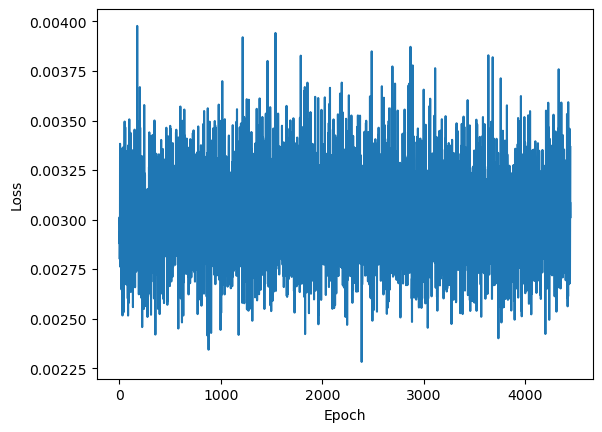

In [ ]:
# plot loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();